In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pathlib import Path
import pandas as pd

file_path = "cyber-threat-intelligence_all.csv"

# 1) Download the raw dataset (zip) and get the local path
dataset_dir = kagglehub.dataset_download("ramoliyafenil/text-based-cyber-threat-detection")
csv_path = Path(dataset_dir) / file_path
print("Downloaded CSV at:", csv_path)

# 2) Read it with a tolerant encoding
df_raw = pd.read_csv(
    csv_path,
    encoding="latin1",      # or "cp1252"
    on_bad_lines="skip",
    engine="python",
)

print("Raw columns:", df_raw.columns.tolist())
print(df_raw.head())

# 3) Save a clean UTF-8 copy INSIDE your repo
clean_path = Path("data")
clean_path.mkdir(exist_ok=True)
utf8_csv = clean_path / "cyber-threat-intelligence_all_utf8.csv"

df_raw.to_csv(utf8_csv, index=False, encoding="utf-8")
print("Saved cleaned CSV to:", utf8_csv.resolve())


Downloaded CSV at: C:\Users\alexg\.cache\kagglehub\datasets\ramoliyafenil\text-based-cyber-threat-detection\versions\1\cyber-threat-intelligence_all.csv
Raw columns: ['Unnamed: 0', 'index', 'text', 'entities', 'relations', 'Comments', 'id', 'label', 'start_offset', 'end_offset']
   Unnamed: 0  index                                               text  \
0           0    1.0  This post is also available in:      æ¥æ¬èª...   
1           1    2.0  The attack vector is very basic and repeats it...   
2           2    3.0  Once executed by the user the first stage malw...   
3           3    4.0   The first known campaign was launched by Crim...   
4           4    5.0  The first stage downloaded the ransomware from...   

                                            entities relations Comments  \
0  [{'id': 45800, 'label': 'malware', 'start_offs...        []       []   
1  [{'id': 48941, 'label': 'attack-pattern', 'sta...        []       []   
2                                           

In [2]:
import pandas as pd

df = pd.read_csv("data/cyber-threat-intelligence_all_utf8.csv")

data = df[["text", "label"]]
print(df["label"].unique())
print(data.head())


['malware' 'attack-pattern' nan 'TIME' 'identity' 'SOFTWARE'
 'threat-actor' 'location' 'tools' 'FILEPATH' 'SHA2' 'vulnerability' 'URL'
 'DOMAIN' 'IPV4' 'campaign' 'EMAIL' 'REGISTRYKEY' 'SHA1' 'Infrastucture'
 'MD5' 'url' 'hash']
                                                text           label
0  This post is also available in:      æ¥æ¬èª...         malware
1  The attack vector is very basic and repeats it...  attack-pattern
2  Once executed by the user the first stage malw...             NaN
3   The first known campaign was launched by Crim...            TIME
4  The first stage downloaded the ransomware from...             NaN


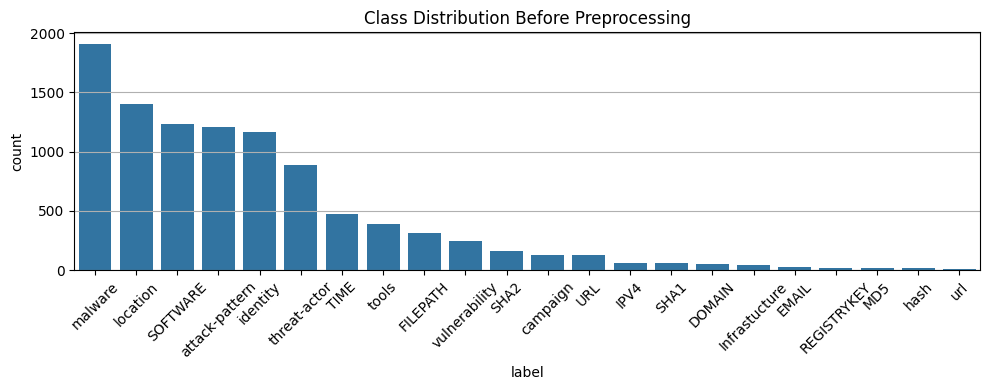

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.countplot(data=data, x='label', order=data['label'].value_counts().index)
plt.title('Class Distribution Before Preprocessing')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Final version

added mAP, modified the pipleline


Proper train/test split before any processing

Augmentation applied only to training data

Class weighting implemented via custom Trainer

mAP calculation added

More efficient tokenization (max_length=128)

Stratified splitting to maintain class ratios

Clean separation between training and evaluation phases

Removed redundant SMOTE (not compatible with text data)

Added proper label encoding workflow

In [8]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import os
import random

print("Imports ok")

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print("NLTK data ready")

Imports ok
NLTK data ready


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
# Load and preprocess dataset
file_path = "cyber-threat-intelligence_all.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "ramoliyafenil/text-based-cyber-threat-detection",
    file_path
)

# ========== NEW LABEL PROCESSING ==========
# Handle NaN values and combine labels
df['label'] = df['label'].fillna('no-threat')

COMBINE_LABELS = [
    "MD5", "REGISTRYKEY", "EMAIL", "Infrastucture", "DOMAIN", "SHA1", "IPV4",
    "campaign", "URL", "SHA2", "vulnerability", "FILEPATH", "tools", "TIME",
    "url", "hash"
]

df['label'] = df['label'].apply(
    lambda x: "NEED_ATTENTION" if x in COMBINE_LABELS else x
)

# Create final dataset (only drop rows with missing text)
data = df[['text', 'label']].dropna(subset=['text'])
# ==========================================

# Initial train/test split (before any processing)
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# ===== Text Augmentation Functions =====
# Get synonyms for a given word using WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return list(synonyms) if synonyms else None

# Replace up to 'n' words in a sentence with synonyms
def synonym_replacement(text, n=1):
    words = word_tokenize(text)
    new_words = words.copy()
    random.shuffle(new_words)
    replaced = 0
    for word in new_words:
        synonyms = get_synonyms(word)
        if synonyms and replaced < n:
            synonym = random.choice(synonyms)
            text = text.replace(word, synonym, 1)
            replaced += 1
    return text

# Perform text augmentation (currently using only synonym replacement)
def text_augmentation(text, augmentations_per_text=2):
    augmented_texts = []
    for _ in range(augmentations_per_text):
        method = random.choice([synonym_replacement])
        augmented_texts.append(method(text))
    return augmented_texts

# Apply text augmentation to the dataset
def augment_dataset(data):
    augmented_texts = []
    augmented_labels = []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Augmenting Data"):
        augmented = text_augmentation(row['text'])
        augmented_texts.extend(augmented)
        augmented_labels.extend([row['label']] * len(augmented))
    return pd.concat([
        data,
        pd.DataFrame({'text': augmented_texts, 'label': augmented_labels})
    ], ignore_index=True)

# Augment only the training data
print(f"Original training size: {len(train_df)}")
train_df = augment_dataset(train_df)
print(f"Augmented training size: {len(train_df)}")

# Encode labels using training data
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label'] = le.transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])
label_names = le.classes_
num_labels = len(label_names)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
).to(device)

# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_strategy="epoch",
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# Train the model
trainer.train()

# Evaluation
predictions = trainer.predict(tokenized_test)
y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_pred = np.argmax(y_probs, axis=1)
y_true = predictions.label_ids

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Calculate mAP
y_true_binarized = np.zeros_like(y_probs)
y_true_binarized[np.arange(len(y_true)), y_true] = 1

average_precisions = []
for class_idx in range(num_labels):
    average_precisions.append(
        average_precision_score(
            y_true_binarized[:, class_idx],
            y_probs[:, class_idx]
        )
    )

mAP = np.mean(average_precisions)
print(f"\nMean Average Precision (mAP): {mAP:.4f}")
print("\nPer-class Average Precision:")
for class_name, ap in zip(label_names, average_precisions):
    print(f"{class_name}: {ap:.4f}")

# Sample predictions
sample_texts = [
    "Subject: Urgent Security Update Required - Click http://secure-update.com",
    "Malicious registry key modification detected in HKLM\\Software\\BadActor",
    "APT29 is using new PowerShell backdoor for data exfiltration",
    "Scheduled maintenance: Run system-patch.exe at 15:00 UTC"
]

for idx, sample_text in enumerate(sample_texts):
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]

    topk = torch.topk(probs, k=3)
    print(f"\n🔍 Sample {idx+1}:")
    print(sample_text)
    print("Top predictions:")
    for i in range(3):
        print(f"  {label_names[topk.indices[i]]}: {topk.values[i]:.4f}")

C:\Users\alexg\AppData\Local\Temp\ipykernel_25644\2506249480.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Original training size: 15952


Augmenting Data: 100%|██████████| 15952/15952 [00:16<00:00, 958.14it/s] 


Augmented training size: 47856
Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/47856 [00:00<?, ? examples/s]

Map:   0%|          | 0/3988 [00:00<?, ? examples/s]

c:\Users\alexg\VisualStudioProjects\cyber-threat-analyzer\backend\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Our Baseline Model:



In [10]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import os

# Load and preprocess dataset
file_path = "cyber-threat-intelligence_all.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "ramoliyafenil/text-based-cyber-threat-detection",
    file_path
)

# Label preprocessing
df['label'] = df['label'].fillna('no-threat')
COMBINE_LABELS = [
    "MD5", "REGISTRYKEY", "EMAIL", "Infrastucture", "DOMAIN", "SHA1", "IPV4",
    "campaign", "URL", "SHA2", "vulnerability", "FILEPATH", "tools", "TIME",
    "url", "hash"
]
df['label'] = df['label'].apply(
    lambda x: "NEED_ATTENTION" if x in COMBINE_LABELS else x
)
data = df[['text', 'label']].dropna(subset=['text'])

# Train/test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Label encoding
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label'] = le.transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])
label_names = le.classes_
num_labels = len(label_names)

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
).to(device)

# Dataset preparation
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# Training
training_args = TrainingArguments(
    output_dir="./baseline_results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_strategy="epoch",
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# Use default Trainer without class weights
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

trainer.train()

# Evaluation
predictions = trainer.predict(tokenized_test)
y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_pred = np.argmax(y_probs, axis=1)
y_true = predictions.label_ids

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.title("Baseline Confusion Matrix")
plt.show()

# mAP Calculation
y_true_binarized = np.zeros_like(y_probs)
y_true_binarized[np.arange(len(y_true)), y_true] = 1

average_precisions = []
for class_idx in range(num_labels):
    average_precisions.append(
        average_precision_score(
            y_true_binarized[:, class_idx],
            y_probs[:, class_idx]
        )
    )

mAP = np.mean(average_precisions)
print(f"\nBaseline Mean Average Precision (mAP): {mAP:.4f}")
print("Per-class Average Precision:")
for class_name, ap in zip(label_names, average_precisions):
    print(f"{class_name}: {ap:.4f}")

C:\Users\alexg\AppData\Local\Temp\ipykernel_16808\591824847.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15952 [00:00<?, ? examples/s]

Map:   0%|          | 0/3988 [00:00<?, ? examples/s]

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [ ]:
from pathlib import Path
import json

save_dir = Path("/content/drive/MyDrive/cyber-threat-analyzer/backend/models/cyber-bert-v1") 
save_dir.mkdir(parents=True, exist_ok=True)

tokenizer.save_pretrained(save_dir)
model.save_pretrained(save_dir)

label_map = {int(i): name for i, name in enumerate(label_names)}
with open(save_dir / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, indent=2)

print("Saved model to:", save_dir)
